# Join the EPA County Air Quality Index (AQI) data

In [1]:
import pandas as pd
import swifter
import numpy as np
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_data = pd.read_csv('../Datasets/training_data_full.csv')
county_fips_data = pd.read_csv('../Datasets/state_and_county_fips_master.csv')
# AQI data
aqi_2016 = pd.read_csv('../Datasets/annual_aqi_by_county_2016.csv')
aqi_2017 = pd.read_csv('../Datasets/annual_aqi_by_county_2017.csv')

In [3]:
county_fips_map = {}
for index, row in county_fips_data.iterrows():
    fips, county_name = row['fips'], row['name']
    county_name = county_name.rsplit(' ', 1)[0]
    county_fips_map[fips] = county_name

In [4]:
training_data['CountyName'] = training_data['CountyFIPS'].swifter.apply(county_fips_map.get)

Pandas Apply:   0%|          | 0/27119 [00:00<?, ?it/s]

# Aggregate both state and county level AQI levels
This is needed because not all counties are represented in the EPA data,\
so will need to fall back to state level data

In [5]:
# need this to default to, just in case county 
def get_state_average_aqi(state_counties_data):
    state = state_counties_data.iloc[0]['State']
    average_aqi = np.mean(state_counties_data['Median AQI'])
    return state, average_aqi

In [6]:
state_aqi_2017 = dict(list(aqi_2017.groupby(['State']).apply(get_state_average_aqi)))
state_aqi_2016 = dict(list(aqi_2016.groupby(['State']).apply(get_state_average_aqi)))

In [7]:
county_aqi_2017 = dict(zip(aqi_2017['County'], aqi_2017['Median AQI']))
county_aqi_2016 = dict(zip(aqi_2016['County'], aqi_2016['Median AQI']))

# Add the 2016 and 2017 data to the dataframe, prioritizing County level data

In [8]:
def get_average_aqi(row, state_aqi, county_aqi):
    global county_data
    global state_data
    state, county_name = itemgetter('StateDesc', 'CountyName')(row)
    if county_name in county_aqi:
        county_data += 1
        return county_aqi[county_name]
    elif state in state_aqi:
        state_data += 1
        return state_aqi[state]
    return None

In [9]:
county_data = 0
state_data = 0
training_data['AQI_2017'] = training_data.apply(lambda row: get_average_aqi(row, state_aqi_2017, county_aqi_2017), axis=1)
print(f'county data usage: {county_data}')
print(f'state data usage: {state_data}')

county data usage: 26053
state data usage: 821


In [10]:
county_data = 0
state_data = 0
training_data['AQI_2016'] = training_data.apply(lambda row: get_average_aqi(row, state_aqi_2016, county_aqi_2016), axis=1)
print(f'county data usage: {county_data}')
print(f'state data usage: {state_data}')

county data usage: 26053
state data usage: 821


# Calculate AQI_trend (percentage AQI change from 2016 to 2017)

In [11]:
training_data['AQI_trend'] = 100 * (training_data['AQI_2017'] - training_data['AQI_2016']) / training_data['AQI_2016']

# Check for outliers

<AxesSubplot:xlabel='AQI_trend'>

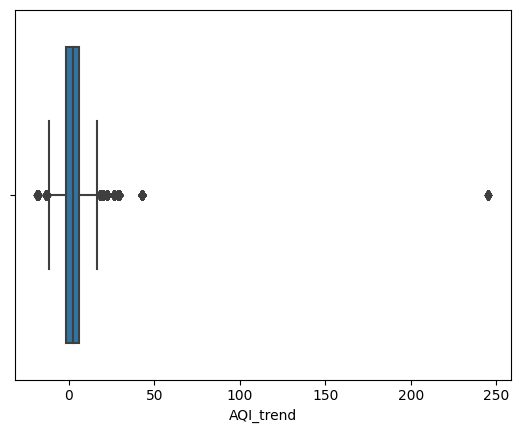

In [12]:
sns.boxplot(x=training_data["AQI_trend"])

In [13]:
training_data.loc[training_data['AQI_trend'] > 200, 'AQI_trend'] = 50

<AxesSubplot:xlabel='AQI_trend'>

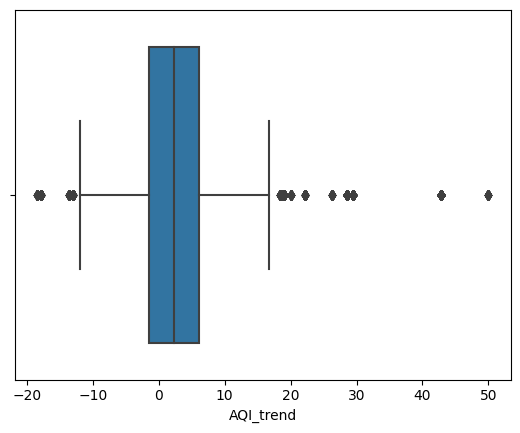

In [14]:
sns.boxplot(x=training_data["AQI_trend"])

## Keep CountyName, AQI_2017, AQI_trend. Drop AQI_2016

In [19]:
training_data.drop(columns=['AQI_2016'], inplace=True)

In [25]:
non_numerical_features = set([
    'StateAbbr',
    'StateDesc',
    'CityName',
    'CountyFIPS',
    'TractFIPS',
    'CountyName'
])

target_features = set([
    'DIABETES_3Y_Change_Percentage'
])

numerical_features = sorted(list(
    set(training_data.columns) - non_numerical_features - target_features
))

In [28]:
column_order = list(non_numerical_features) + numerical_features + list(target_features)

In [29]:
training_data = training_data[column_order]

In [32]:
training_data.to_csv('../Datasets/training_data_with_aqi.csv', index=False)